# Importación de Librerías

In [372]:
# Pandas para manejo de dataframes
import pandas as pd
# Numpy para operaciones matemáticas y vectores
import numpy as np
# SkLearn Suite para preprocesamiento, modelación, reducción de dimensionalidad y evaluación.
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
# Keras para implementar redes neuronales secuenciales
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from scikeras.wrappers import KerasClassifier
# Herramientas de Visualización y Gráficos
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones

In [ ]:
# Funcion para graficar el historial extraído del entrenamiento de una red neuronal.
def graphHistory(history, title):
    historial_entrenamiento = history

    # Lista con los valores de la función de pérdida en cada época para el conjunto de entrenamiento
    perdida_entrenamiento = historial_entrenamiento.history["loss"]

    # Lista con los valores de la función de pérdida en cada época para el conjunto de validación
    perdida_validacion = historial_entrenamiento.history["val_loss"]

    # Lista con los valores de precisión en cada época para el conjunto de entrenamiento
    precision_entrenamiento = historial_entrenamiento.history["accuracy"]

    # Lista con los valores de precisión en cada época para el conjunto de validación
    precision_validacion = historial_entrenamiento.history["val_accuracy"]

    # Crear un rango de números desde 1 hasta el número de épocas para el eje x
    epocas = range(1, len(perdida_entrenamiento) + 1)

    # Gráfica de la pérdida durante el entrenamiento
    plt.figure(figsize=(10,5))  # Tamaño de la figura (ancho, alto)

    # Graficar la pérdida de entrenamiento
    plt.plot(epocas, perdida_entrenamiento, "b-", label="Pérdida Entrenamiento")

    # Graficar la pérdida de validación
    plt.plot(epocas, perdida_validacion, "r-", label="Pérdida Validación")

    plt.title("Curvas de Pérdida | "+title)  # Título de la gráfica
    plt.xlabel("Época")             # Etiqueta del eje X
    plt.ylabel("Pérdida")           # Etiqueta del eje Y
    plt.legend()                     # Mostrar leyenda con etiquetas definidas
    plt.grid(True)                   # Mostrar cuadrícula para mejor visualización
    plt.show()                     

    # Gráfica de la precisión durante el entrenamiento
    plt.figure(figsize=(10,5))  

    # Graficar la precisión del entrenamiento
    plt.plot(epocas, precision_entrenamiento, "b-", label="Precisión Entrenamiento")

    # Graficar la precisión de validación
    plt.plot(epocas, precision_validacion, "r-", label="Precisión Validación")

    plt.title("Curvas de Exactitud | "+title)  # Título de la gráfica
    plt.xlabel("Época")               # Etiqueta del eje X
    plt.ylabel("Precisión")           # Etiqueta del eje Y
    plt.legend()                       # Mostrar leyenda
    plt.grid(True)                     # Mostrar cuadrícula
    plt.show()  

# Función para mostrar los elementos unicos dentro de un vector y su frecuencia
def showUniqueCounts(vector: np.array):
    uniq =  np.unique_counts(vector)
    for i in range(len(uniq.values)):
        print("Count: ", uniq.counts[i], "  |  Value: ", uniq.values[i])

# Función para calcular ROC AUC multiclase
def calcROCAUC(y_pred, y_true, nclasses):

    # Convertir y_true a arreglo de numpy
    Ytest_onehot = y_true.to_numpy() 
    
    # diccionario para almacenar auc scores para cada clase
    auc_scores = {}

    for i in range(nclasses):
        # Calcular ROC AUC para cada clase
        auc_scores[i] = roc_auc_score(Ytest_onehot[:, i], y_pred[:, i])
    
    # Diccionarios para almacenar el False Positive Rate (fpr) y True Positive Rate (tpr) para cada clase:
    fpr = dict()
    tpr = dict()
    for i in range(nclasses):
    # Calcular curva ROC para cada clase
        fpr[i], tpr[i], _ = roc_curve(Ytest_onehot[:, i], y_pred[:, i])

    return fpr, tpr, auc_scores

# Función para graficar las curvas ROC AUC
def graphROCAUC(y_pred, y_test_oneHot, nclasses, title):
    fpr, tpr, auc_scores = calcROCAUC(y_pred, y_test_oneHot, nclasses)

     # Crear figura
    fig = go.Figure()

    # Añadir una curva ROC por clase
    for i in range(nclasses):
        fig.add_trace(go.Scatter(
            # False Positive Rate 
            x=fpr[i],
            # True Positive Rate 
            y=tpr[i],
            # Mostrar líneas
            mode='lines',
            # Configrar label
            name=f'Class {i} (AUC={auc_scores[i]:.2f})'  
    ))
    
    # Añadir diagonal de referencia
    fig.add_trace(go.Scatter(
        x=[0,1], y=[0,1],
        mode='lines',
        line=dict(dash='dash', color='gray'), 
        showlegend=False 
    ))

    # Personalizar el formato 
    fig.update_layout(
        title="Curvas ROC Multiclase | "+title,
        # Plot title
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        template="plotly_white",
        width=1000, height=600
    )
    fig.show() 

# Función para calcular y graficar una matriz de confusión
def graphConfusionMatrix(y_true, y_pred, title, categories):
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Plots
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.title("Matriz de Confusión | "+title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Función para convertir classification_report en DataFrame
def report_to_df(report):
    df = pd.DataFrame(report).transpose()
    df = df.iloc[:-3, :]  # excluir 'accuracy', 'macro avg', 'weighted avg'
    return df[['precision', 'recall', 'f1-score']]

# Comprensión de los Datos

## Lectura de Datos

In [ ]:
# Ruta del achivo
path = "/dev/data/cicids2017_cleaned.csv"

# Lectura de datos y transformación a pd.DataFrame para su manipulación
data = pd.read_csv(path)

## Exploración de Datos

In [315]:
# Explorar una muestra de los primeros 5 registros
print(data.head())

   Destination Port  Flow Duration  Total Fwd Packets  \
0                22        1266342                 41   
1                22        1319353                 41   
2                22            160                  1   
3                22        1303488                 41   
4             35396             77                  1   

   Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                         2664                    456                      0   
1                         2664                    456                      0   
2                            0                      0                      0   
3                         2728                    456                      0   
4                            0                      0                      0   

   Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  \
0               64.975610             109.864573                    976   
1               64.975610 

In [ ]:
# Mostrar información general sobre las características contenidas en las muestras
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int64  
 17  Flow IAT Min                 int64  
 18  Fwd IAT Total                int64  
 19  

In [317]:
# Exploración de datos
print(data.describe())

       Destination Port  Flow Duration  Total Fwd Packets  \
count      2.520751e+06   2.520751e+06       2.520751e+06   
mean       8.690744e+03   1.659032e+07       1.025880e+01   
std        1.901294e+04   3.523140e+07       7.943824e+02   
min        0.000000e+00  -1.300000e+01       1.000000e+00   
25%        5.300000e+01   2.080000e+02       2.000000e+00   
50%        8.000000e+01   5.062000e+04       2.000000e+00   
75%        4.430000e+02   5.332968e+06       6.000000e+00   
max        6.553500e+04   1.200000e+08       2.197590e+05   

       Total Length of Fwd Packets  Fwd Packet Length Max  \
count                 2.520751e+06           2.520751e+06   
mean                  6.065243e+02           2.311993e+02   
std                   1.011595e+04           7.563122e+02   
min                   0.000000e+00           0.000000e+00   
25%                   1.200000e+01           6.000000e+00   
50%                   6.600000e+01           4.000000e+01   
75%                   3

In [ ]:
# Mostrar frecuencia de cada clase
print(data["Attack Type"].value_counts())

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64


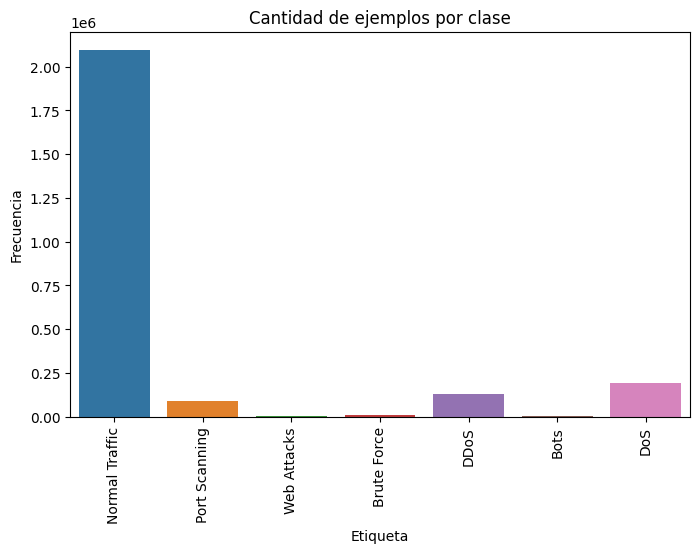

In [319]:
# Clases unicas
plt.figure(figsize=(8,5))
sns.countplot(data=data, x="Attack Type", hue="Attack Type")

# Rotar etiquetas en X
plt.xticks(rotation=90)

plt.title("Cantidad de ejemplos por clase")
plt.xlabel("Etiqueta")
plt.ylabel("Frecuencia")
plt.show()

# Preparación de los Datos

## Balanceo de Datos

Se puede observar un claro desbalance en el número de muestras existentes por cada etiqueta, siendo que la etiqueta de mayor frecuencia es "Normal Traffic" con más de 2 millones de muestras, mientras que para clases como Bots tienen menos de 10,000 muestras. Para efectos del análisis que se desea realizar, se recortará el número de muestras por cada etiqueta a la frecuencia mínima encontrada entre las clases. Las muestras son extraídas de forma aleatoria para procurar la generalización de los modelos.

In [ ]:
valuecounts = data["Attack Type"].value_counts()

# número mínimo de muestras por categoría
min_count = valuecounts.min()  
print("Frecuencia mínima: ",min_count)

Frecuencia mínima:  1948


In [321]:
# Cortar la cantidad de datos para balancear las muestras
# Tomar min_count muestras aleatorias de cada categoría
balanced_df = data.groupby("Attack Type").sample(n=min_count, random_state=42)

# Motrar nuevas proporciones de las categorías
df = balanced_df
print(df["Attack Type"].value_counts())

Attack Type
Bots              1948
Brute Force       1948
DDoS              1948
DoS               1948
Normal Traffic    1948
Port Scanning     1948
Web Attacks       1948
Name: count, dtype: int64


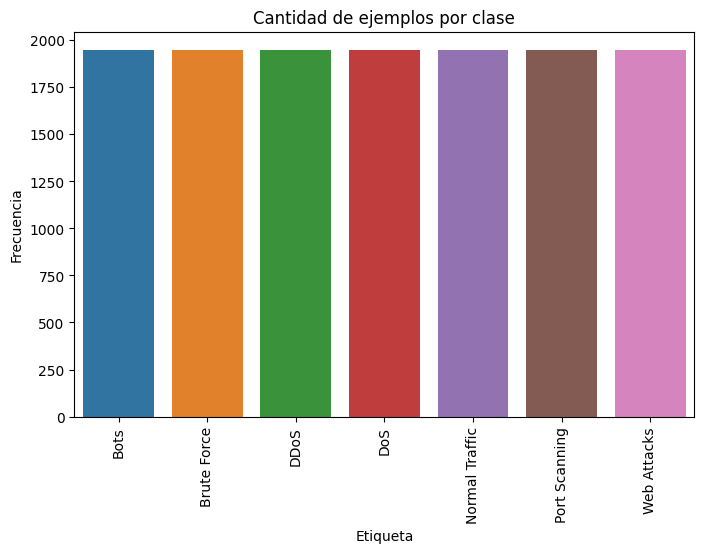

In [322]:
# Clases unicas
plt.figure(figsize=(8,5))
sns.countplot(data=balanced_df, x="Attack Type", hue="Attack Type")

# Rotar etiquetas en X
plt.xticks(rotation=90)

plt.title("Cantidad de ejemplos por clase")
plt.xlabel("Etiqueta")
plt.ylabel("Frecuencia")
plt.show()

## Análisis de Correlación entre Variables

A continuación se presenta una matriz que muestra la correlación presentada entre las 52 variables numéricas involucradas para evaluar una posible reducción de dimensionalidad previo a la modelación.

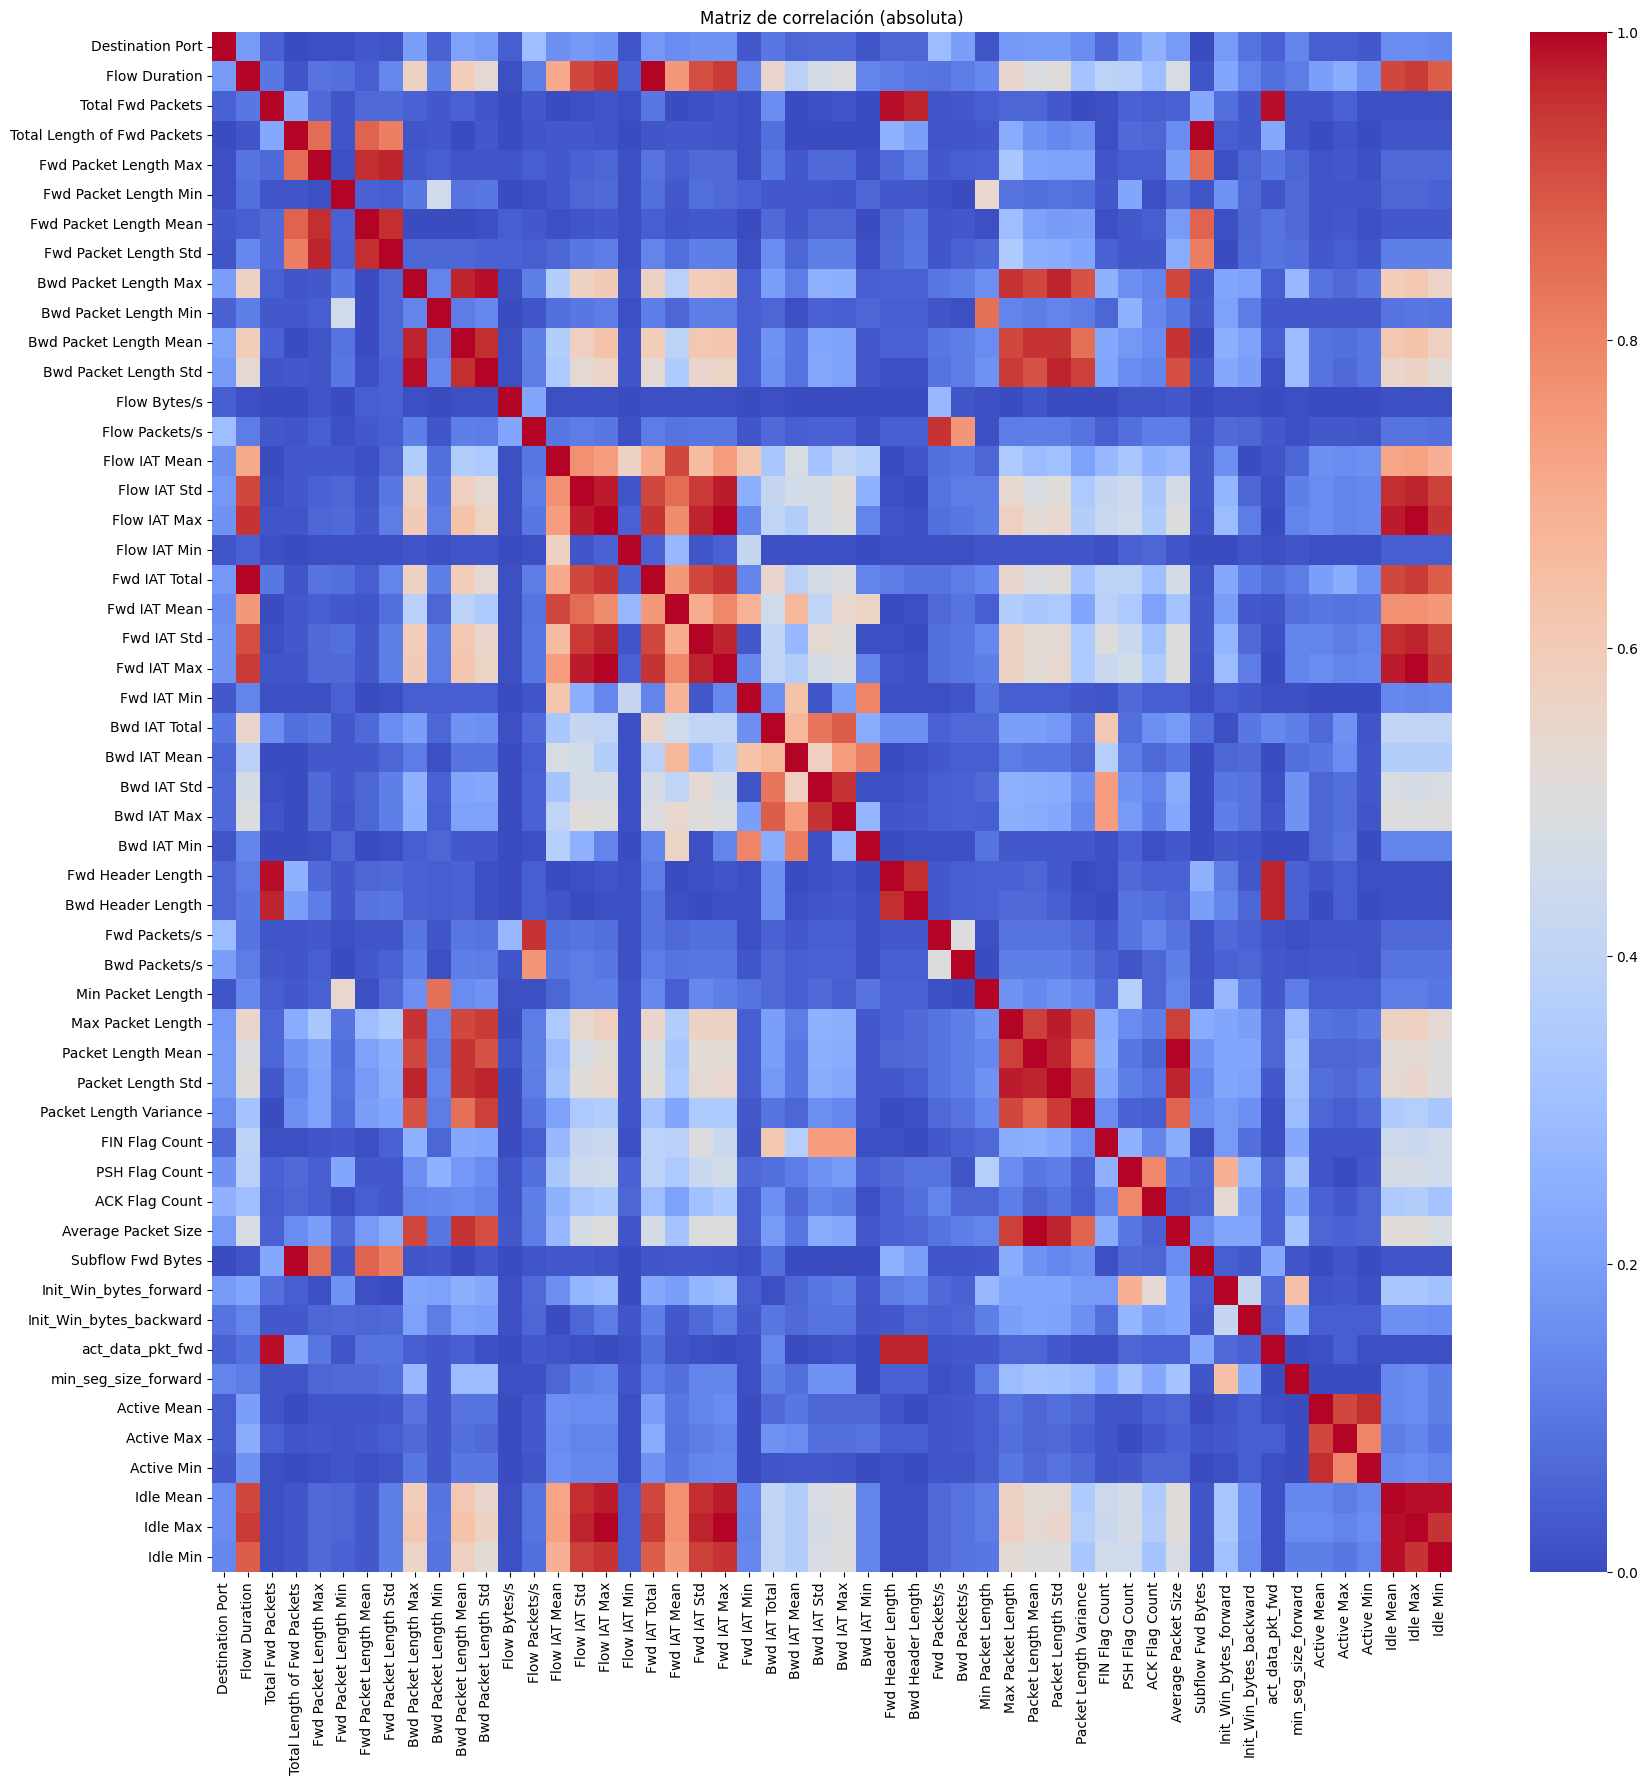

In [323]:
corr_matrix = balanced_df.corr(numeric_only=True).abs().round(2)

# Matriz de correlación (para ver variables relacionadas)
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Matriz de correlación (absoluta)")
plt.show()

Se puede observar que existen ciertos grupos de variables que presentan un alto factor de correlación, por lo que se realizará una selección de características en cuestión de reducción de dimensionalidad.

## Separación de Conjuntos de Datos

A continuación se realiza la separación de las muestras y las etiquetas para la clasficación. Además se construyen los conjuntos de entrenamiento y prueba dejando 20% de las muestras para la prueba. Además, se verifica la frecuencia de las muestras para asegurar el balance entre los conjuntos de entrenamiento y prueba realizado.

In [324]:
# Separación de los vectores de características y atributo clasificador
X = balanced_df.drop(columns="Attack Type")
Y = balanced_df["Attack Type"]

In [325]:
# Separación de datos
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Comprobación de balanceo de datos
print("======= y_train:")
showUniqueCounts(y_train)

print("\n======= y_test: ")
showUniqueCounts(y_test)

# Dimenisones de los conjuntos de datos
print("\nXtrain shape: ", X_train.shape)
print("Ytrain shape: ", y_train.shape)
print("Xtest shape : ", X_test.shape)
print("Ytest shape : ", y_test.shape)

======= y_train:
Count:  1559   |  Value:  Bots
Count:  1559   |  Value:  Brute Force
Count:  1558   |  Value:  DDoS
Count:  1558   |  Value:  DoS
Count:  1558   |  Value:  Normal Traffic
Count:  1558   |  Value:  Port Scanning
Count:  1558   |  Value:  Web Attacks

======= y_test: 
Count:  389   |  Value:  Bots
Count:  389   |  Value:  Brute Force
Count:  390   |  Value:  DDoS
Count:  390   |  Value:  DoS
Count:  390   |  Value:  Normal Traffic
Count:  390   |  Value:  Port Scanning
Count:  390   |  Value:  Web Attacks

Xtrain shape:  (10908, 52)
Ytrain shape:  (10908,)
Xtest shape :  (2728, 52)
Ytest shape :  (2728,)


## Escalamiento de datos

In [326]:
# Escalamiento de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # usar mismo scaler

## Reducción de Dimensionalidad: PCA

En esta sección se presenta el proceso realizado de reducción de dimensionalidad mediante la técnica PCA (Principal Component Analysis) para conservar las variables que mejor expliquen varianza de los datos y poder eliminar las sobrantes.

In [327]:
# PCA para reducción de dimensionalidad.
pca = PCA(n_components=X_train.shape[1], random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

A continuación se presenta la varianza explicada por cada componente creado al crear una cantidad de componentes igual a la cantidad de variables.

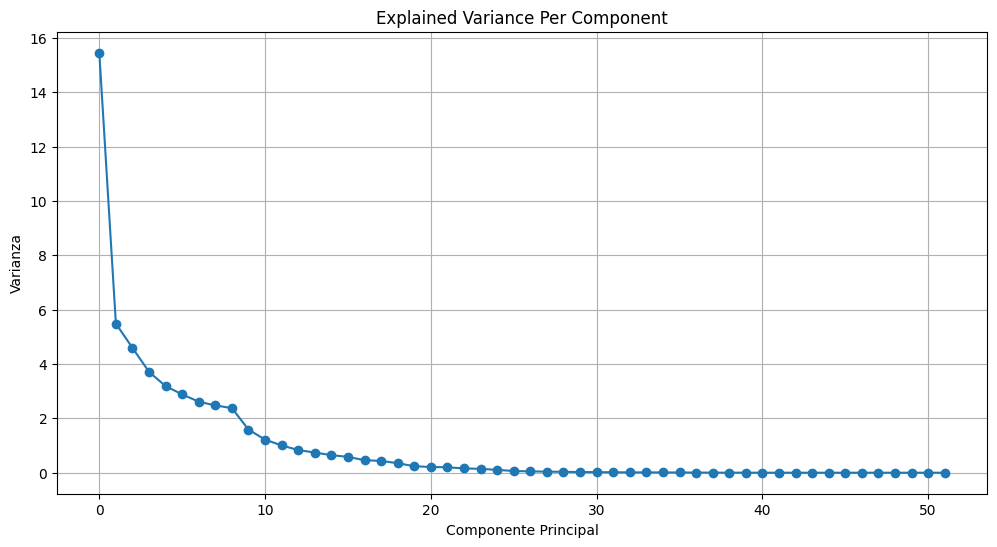

In [328]:
# Explained Variance
plt.figure(figsize=(12, 6))
plt.plot(pca.explained_variance_, marker='o')
plt.title('Explained Variance Per Component')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza')
plt.grid(True)
plt.show()

En el siguiente gráfico se presenta un pie chart donde se pueda apreciar la proporción de la varianza explicada por cada uno de los componentes generados.

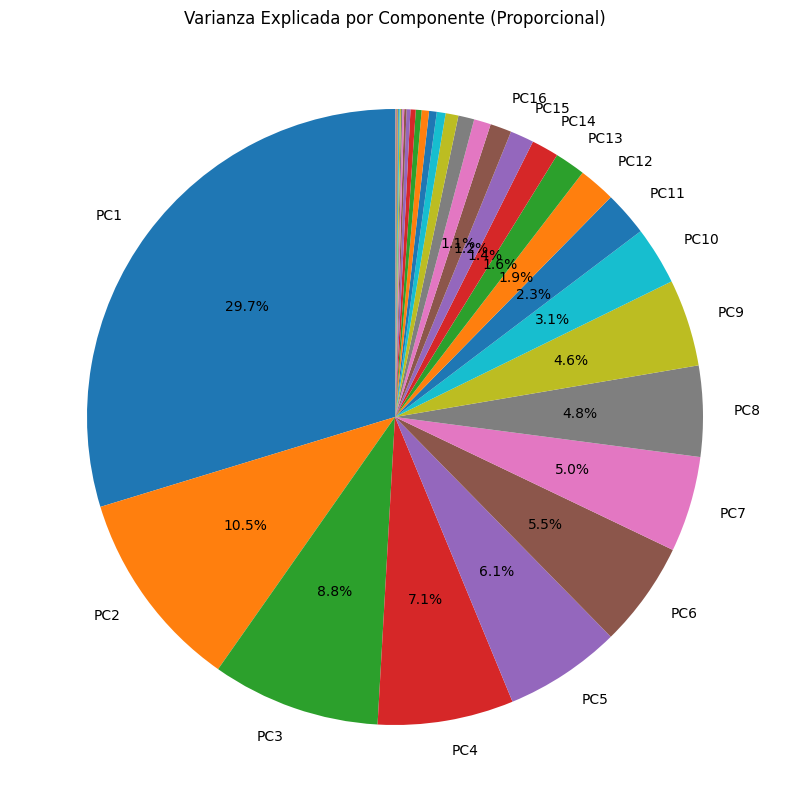

In [329]:
# Pie chart - (Explained Variance Ratio)
expl_var = pca.explained_variance_ratio_
labels = [f'PC{i+1}' for i in range(len(expl_var))]
threshold = 0.01  # mostrar solo si la proporción > 1%

def autopct_filter(pct):
    return f'{pct:.1f}%' if pct/100 > threshold else ''

plt.figure(figsize=(11, 10))
wedges, texts, autotexts = plt.pie(
    expl_var,
    labels=labels,
    autopct=autopct_filter,
    startangle=90
)

# Ocultar labels y porcentajes para porciones pequeñas
for i, w in enumerate(wedges):
    if expl_var[i] < threshold:
        texts[i].set_text('')
        autotexts[i].set_text('')

plt.title('Varianza Explicada por Componente (Proporcional)')
plt.show()

De acuerdo con el gráfico anterior se decidió utilizar los primeros 10 componentes para conseguir realizar la modelación con características que expliquen mínimo el 85% de la varianza total.

In [330]:
print("\n=== Varianza Explicada (ratio) por los primeros 10 PCA Component: ")
desiredVariance = 0
for i in range(len(pca.explained_variance_ratio_[:10])):
    print("C",i," -> ", np.round(pca.explained_variance_ratio_[i], 6))
    desiredVariance+=pca.explained_variance_ratio_[i]

print("Varianza Explicada Total: ", desiredVariance)

print(X_train_pca.shape)


=== Varianza Explicada (ratio) por los primeros 10 PCA Component: 
C 0  ->  0.29714
C 1  ->  0.105486
C 2  ->  0.088357
C 3  ->  0.071327
C 4  ->  0.06125
C 5  ->  0.055422
C 6  ->  0.050245
C 7  ->  0.047618
C 8  ->  0.045698
C 9  ->  0.03052
Varianza Explicada Total:  0.8530621044929216
(10908, 52)


Se reconstruyen los conjuntos de muestras conservando así únicamente 10 variables para el modelado. 

In [331]:
X_train_pca = X_train_pca[: , :10]
X_test_pca = X_test_pca[: , :10]
print(X_train_pca.shape)
print(X_test_pca.shape)

(10908, 10)
(2728, 10)


Se contruyen dos versiones de los vectores de etiquetas:
- One Hot Encoded
- Categorical Encoding

Ambas expresiones serán de utilidad en las secciones posteriores.

In [332]:
y_train_oneHot = pd.get_dummies(y_train)
y_test_oneHot = pd.get_dummies(y_test)
print(y_train_oneHot.shape)
print(y_test_oneHot.shape)

(10908, 7)
(2728, 7)


In [333]:
encoder = LabelEncoder()
y_test_cat_encoded = encoder.fit_transform(y_test)
print(y_test_cat_encoded)

[0 0 1 ... 6 4 6]


In [334]:
categories = np.unique_values(y_test)
for cat in categories:
    print(cat)

n_categories = len(categories)
print("\nNúmero de categorias: ", n_categories)

Bots
Brute Force
DDoS
DoS
Normal Traffic
Port Scanning
Web Attacks

Número de categorias:  7


# Modelación

Se emplearan dos enfoques para modelar los datos analizados y lograr una clasificación multinomial para la salida:
- Aprendizaje Automático Supervisado: Regresión Logística (Scikit-Learn)
- Deep Learning: Redes Neuronales Densas (Tensorflow.Keras)

## Regresión Logística

### Implementación y Entrenamiento

A continuación se presenta la implemenatción de la Regresión Logística mediante el uso de GridSearchCV(), siendo este una herramienta que proporciona Scikit-Learn para realizar pruebas sistemáticas de hiperparámetros con el objetivo de encontrar los parámetros ideales para obtener un modelo eficiente. Esta procedimiento incluye la combinación de constantes de regularización, penalización, solvers, número de iteraciones y balanceo de pesos. Los modelos se análizan dentro de un número k de particiones para implementar la técnica de cross-validation y reforzar el resultado obtenido. La métrica utilizada para escoger el mejor modelo es el f1-score.

Despúes de la ejecución del proceso se puede observar el mejor modelo obtenido, así como los parámetros utilizados para construirlo.

In [ ]:
# Crear el modelo base
logreg = LogisticRegression(random_state=42)

# Grid de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'saga'],  
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}

# GridSearchCV
grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,  # cross-validation 
    scoring='f1_weighted',
    n_jobs=-1
)

# Entrenar en el set de entrenamiento balanceado
grid.fit(X_train_pca, y_train)

In [336]:
# Mejor modelo y parámetros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score (CV):", grid.best_score_)

Mejores hiperparámetros: {'C': 100, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Mejor score (CV): 0.9079634757348221


### Evaluación del Modelo

A continuación se muestran las métricas obtenidas al utilizar el conjunto de datos de prueba y así lograr obtener una perspectiva general de la eficiencia del modelo.

In [337]:
# Predicciones sobre test
y_pred = grid.predict(X_test_pca)

reglogResults = classification_report(y_test, y_pred, output_dict=True)

print(reglogResults)

{'Bots': {'precision': 0.8491484184914841, 'recall': 0.897172236503856, 'f1-score': 0.8725, 'support': 389.0}, 'Brute Force': {'precision': 0.8399122807017544, 'recall': 0.9845758354755784, 'f1-score': 0.906508875739645, 'support': 389.0}, 'DDoS': {'precision': 0.9605911330049262, 'recall': 1.0, 'f1-score': 0.9798994974874372, 'support': 390.0}, 'DoS': {'precision': 0.9650537634408602, 'recall': 0.9205128205128205, 'f1-score': 0.9422572178477691, 'support': 390.0}, 'Normal Traffic': {'precision': 0.819620253164557, 'recall': 0.6641025641025641, 'f1-score': 0.7337110481586402, 'support': 390.0}, 'Port Scanning': {'precision': 0.9798488664987406, 'recall': 0.9974358974358974, 'f1-score': 0.98856416772554, 'support': 390.0}, 'Web Attacks': {'precision': 0.9459459459459459, 'recall': 0.8974358974358975, 'f1-score': 0.9210526315789473, 'support': 390.0}, 'accuracy': 0.908724340175953, 'macro avg': {'precision': 0.9085886658926098, 'recall': 0.9087478930666592, 'f1-score': 0.9063562055054256

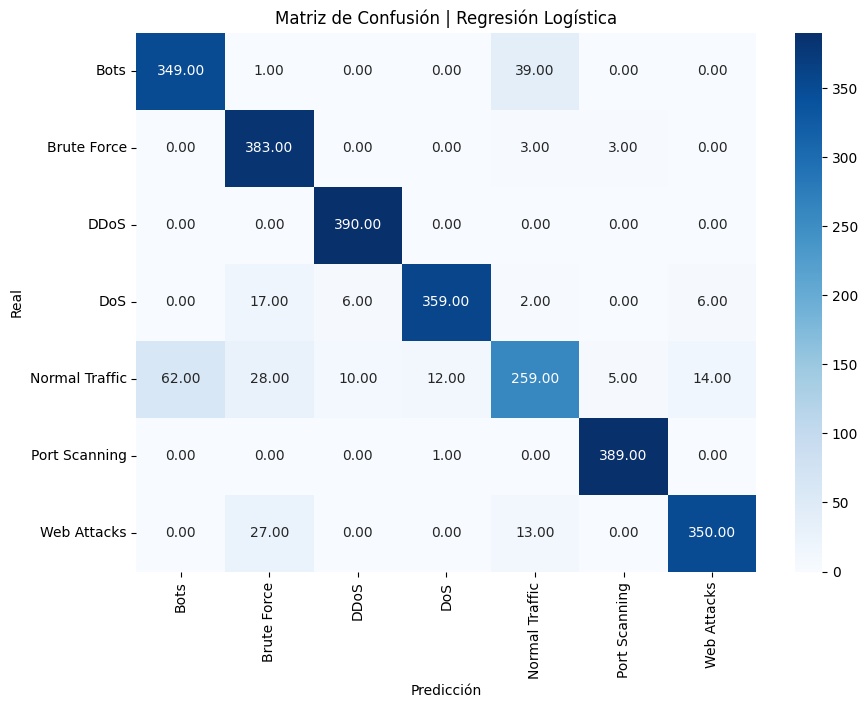

In [338]:
# Matriz de Confusión

# Calcular la matriz de confusión obtenida para la clasificación multiclase
cm = confusion_matrix(y_test, y_pred)

# Plots
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confusión | Regresión Logística")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

## Red Neuronal Densa

En esta sección se implementará el clasificador multiclase mediante un enfoque de red neuronal densa. Al igual que en la implementación de Regresión Logística, se realizará un proceso de experimentación para obtener el modelo más eficiente y los parámetros que utiliza. 

Para todas las arquitecturas se utilizaran 10 neuronas de entrada resultantes del análisis PCA realizado y 7 neuronas de salida correspondientes al número de clases que se pretende obtener.

In [339]:
n_input_neurons = X_train_pca.shape[1]
n_output_neurons = n_categories

print("N_neuronas de Entrada: ", n_input_neurons)
print("N_neuronas de Salida : ", n_output_neurons)

N_neuronas de Entrada:  10
N_neuronas de Salida :  7


### Implementación y Entrenamiento

A continuación se presenta la función que implementa una red neurnal densa para un número de capas neuronales deseado entrenandola sobre un conjunto de datos dado.

In [340]:
# Función que recibe una arquitectura de red determinada, compila y entrena la red neuronal.n_output_neurons
# Input:
#   - X_train: Conjunto de muestras de entrenamiento
#   - X_test: Conjunto de muestras de prueba
#   - Y_train: Conjunto de etiquetas correpondientes a las muestras de entrenamiento
#   - Y_test: Conjunto de etiquetas correspondientes a las muestras de prueba
#   - n_neurons: Arreglo con arquitectura definida para la red 
#   - loss: métrica de calculo para la perdida durate el entrenamiento de la red
#   - metrics: métricas a evaluar sobre el entrenamiento de la red
#   - EPOCHS: épocas a ejecutar la optimización de pesos de las neuronas
#   - batchSize: Tamaño del batch de datos a utilizar para la optimización de pesos
#   - lr: learning_rate para el optimizador de la red
# Return:
#   - history: diccionario de resultados obtenidos y medidas de aprendizaje obtenidas
#   - nnmodel: modelo resultante
def execNN(X_train, X_test, Y_train, Y_test, n_neurons, loss, metrics, EPOCHS, batchSize, lr):
    # Objeto de keras para modelar una red neuronal densa multicapa de forma secuencial
    nnmodel = Sequential()

    # Construcción de arquitectura determinada
    nnmodel.add(Dense(n_neurons[0][0], activation=n_neurons[0][1], input_shape=(n_neurons[0][0],)))

    for i in range(1,len(n_neurons)):
        nnmodel.add(Dense(n_neurons[i][0], activation=n_neurons[i][1]))

    # Optimizador utilizado
    opt = optimizers.Adam(learning_rate=lr)

    # Compilar modelo
    nnmodel.compile(optimizer=opt, loss=loss, metrics=metrics)

    # Entrenamiento del modelo
    history = nnmodel.fit(X_train, Y_train, epochs=EPOCHS, batch_size=batchSize, verbose=True, validation_data=(X_test, Y_test))

    return history, nnmodel

#### Primer Red Neuronal: 2 Capas Densas (20 y 10 neuronas respectivamente)

##### Entrenamiento

In [341]:
rn1_title = "Primer Red Neuronal: 2 Capas Densas (20 y 10 neuronas respectivamente)"

# Definición de parámetros a utilizar
METRICS = ["accuracy"]
LOSS = "categorical_crossentropy"
EPOCHS = 50
BATCHSIZE = 500

# Definición de arquitectura y funciones de activación para las capas neuronales
n_neurons = [
    (X_train_pca.shape[1], 'relu'),
    (20, 'relu'),
    (10, 'relu'),
    (n_output_neurons, 'softmax')
]

# Ejecución y entrenamiento del modelo definido
rn1_history, rn1_model = execNN(X_train_pca, X_test_pca, y_train_oneHot, y_test_oneHot, n_neurons, LOSS, METRICS, EPOCHS, BATCHSIZE, lr=0.01)

Epoch 1/50


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2832 - loss: 1.7247 - val_accuracy: 0.3816 - val_loss: 1.3961
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6593 - loss: 1.0394 - val_accuracy: 0.8398 - val_loss: 0.6280
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8728 - loss: 0.4749 - val_accuracy: 0.9073 - val_loss: 0.4092
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9159 - loss: 0.3265 - val_accuracy: 0.9142 - val_loss: 0.3169
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9226 - loss: 0.2730 - val_accuracy: 0.9278 - val_loss: 0.2724
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9290 - loss: 0.2455 - val_accuracy: 0.9340 - val_loss: 0.2557
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9374 - loss: 0.2268 - val_accuracy: 0.9362 - val_loss: 0.2372
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9422 - loss: 0.2081 - val_accuracy: 0.9388 - val_loss: 0.2114
Ep

##### Cruvas de Aprendizaje

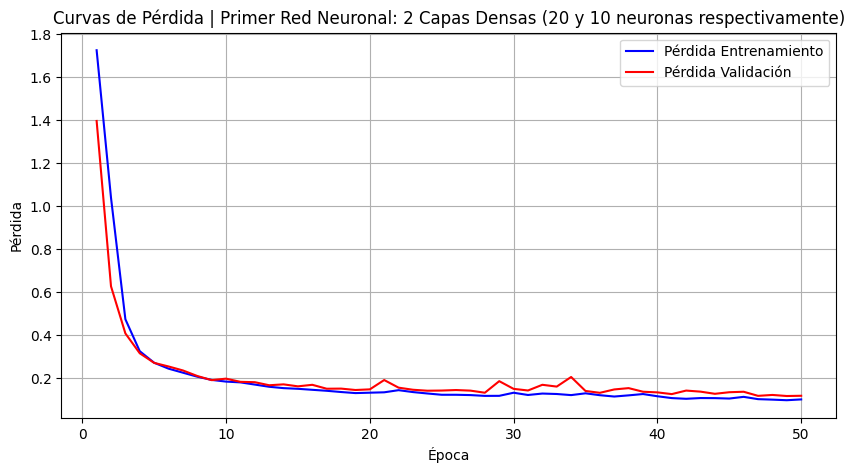

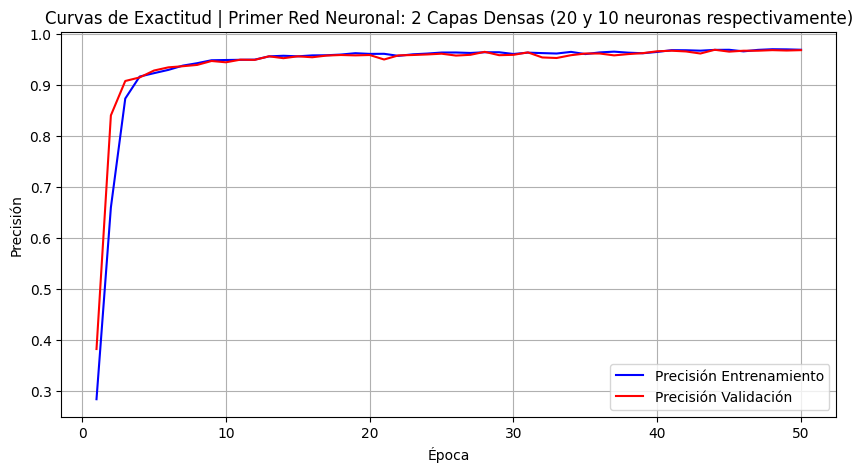

In [342]:
# Graficar curvas de aprendizaje obtenidas por el modelo
graphHistory(rn1_history, rn1_title)

##### Evaluación del Modelo

In [343]:
# Predicciones sobre conjunto de prueba
y_pred = rn1_model.predict(X_test_pca)

# Convertir a etiquetas predichas tomando la clase con mayor probabilidad
predicciones_clase = np.argmax(y_pred, axis=1)

# Métricas de evaluación obtenidas por el modelo
rn1_Results = classification_report(y_test_cat_encoded, predicciones_clase, output_dict=True)

print(rn1_Results)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
{'0': {'precision': 0.9690721649484536, 'recall': 0.9665809768637532, 'f1-score': 0.9678249678249679, 'support': 389.0}, '1': {'precision': 0.9593908629441624, 'recall': 0.9717223650385605, 'f1-score': 0.9655172413793104, 'support': 389.0}, '2': {'precision': 0.9923469387755102, 'recall': 0.9974358974358974, 'f1-score': 0.9948849104859335, 'support': 390.0}, '3': {'precision': 0.9741602067183462, 'recall': 0.9666666666666667, 'f1-score': 0.9703989703989704, 'support': 390.0}, '4': {'precision': 0.9442970822281167, 'recall': 0.9128205128205128, 'f1-score': 0.9282920469361148, 'support': 390.0}, '5': {'precision': 0.974937343358396, 'recall': 0.9974358974358974, 'f1-score': 0.9860583016476553, 'support': 390.0}, '6': {'precision': 0.959079283887468, 'recall': 0.9615384615384616, 'f1-score': 0.9603072983354674, 'support': 390.0}, 'accuracy': 0.967741935483871, 'macro avg': {'precision': 0.967611983265779, 'recall': 0.9677429682571072, 'f1-score': 0.

In [344]:
# Graficación de curvas ROCAUC para evaluar la clasificación del modelo
graphROCAUC(y_pred, y_test_oneHot, n_categories, rn1_title)

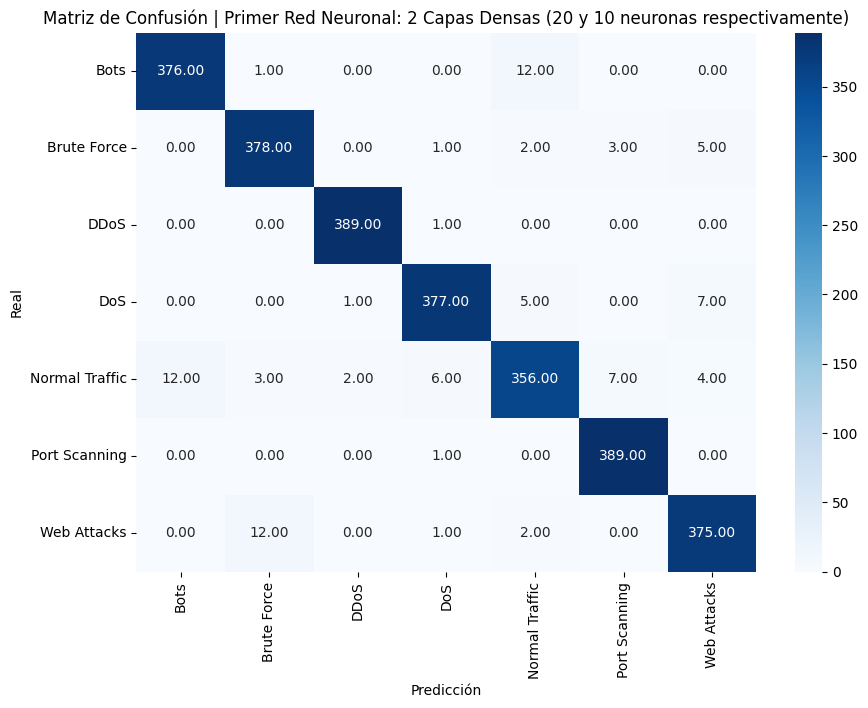

In [345]:
# Matriz de Confusión

# Convertir a etiquetas enteras
y_true_labels = np.argmax(y_test_oneHot, axis=1)

# Tomar la clase con máxima probabilidad
y_pred_labels = np.argmax(y_pred, axis=1)

# Graficar Matriz de Confusión
graphConfusionMatrix(y_true_labels, y_pred_labels, rn1_title, categories)

#### Segunda Red Neuronal: 4 Capas Densas (20, 30, 20 y 10 neuronas respectivamente)

##### Entrenamiento

In [346]:
rn2_title = "Segunda Red Neuronal: 4 Capas Densas (20, 30, 20 y 10 neuronas respectivamente)"

# Definición de parámetros a utilizar
METRICS = ["accuracy"]
LOSS = "categorical_crossentropy"
EPOCHS = 30
BATCHSIZE = 1000

# Definición de arquitectura y funciones de activación para las capas neuronales
n_neurons = [
    (X_train_pca.shape[1], 'relu'),
    (20, 'relu'),
    (30, 'relu'),
    (20, 'relu'),
    (10, 'relu'),
    (n_output_neurons, 'softmax')
]

# Ejecución y entrenamiento del modelo definido
rn2_history, rn2_model = execNN(X_train_pca, X_test_pca, y_train_oneHot, y_test_oneHot, n_neurons, LOSS, METRICS, EPOCHS, BATCHSIZE, lr=0.01)

Epoch 1/30


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.3661 - loss: 1.6601 - val_accuracy: 0.4586 - val_loss: 1.3024
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5921 - loss: 1.0868 - val_accuracy: 0.7122 - val_loss: 0.8549
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7676 - loss: 0.7188 - val_accuracy: 0.8295 - val_loss: 0.5636
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8758 - loss: 0.4682 - val_accuracy: 0.9040 - val_loss: 0.3686
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8994 - loss: 0.3364 - val_accuracy: 0.9062 - val_loss: 0.3034
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9133 - loss: 0.2822 - val_accuracy: 0.9230 - val_loss: 0.2563
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9264 - loss: 0.2384 - val_accuracy: 0.9326 - val_loss: 0.2240
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9339 - loss: 0.2164 - val_accuracy: 0.9355 - val_loss: 0.2123
E

##### Curvas de Aprendizaje

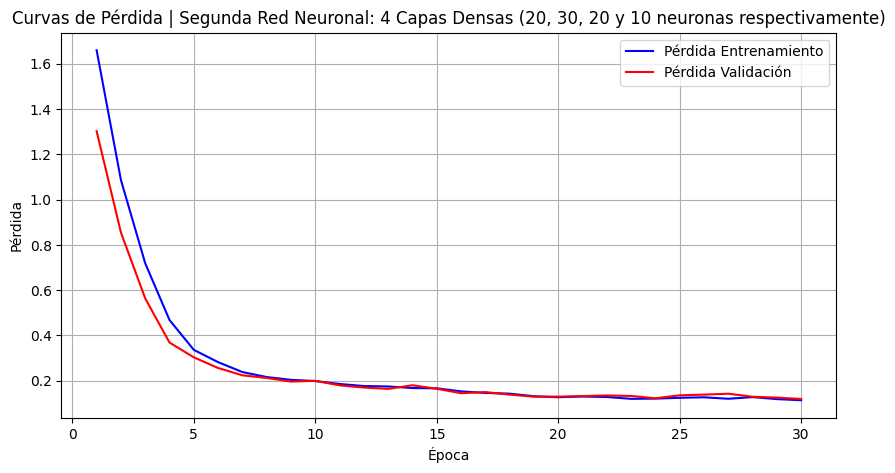

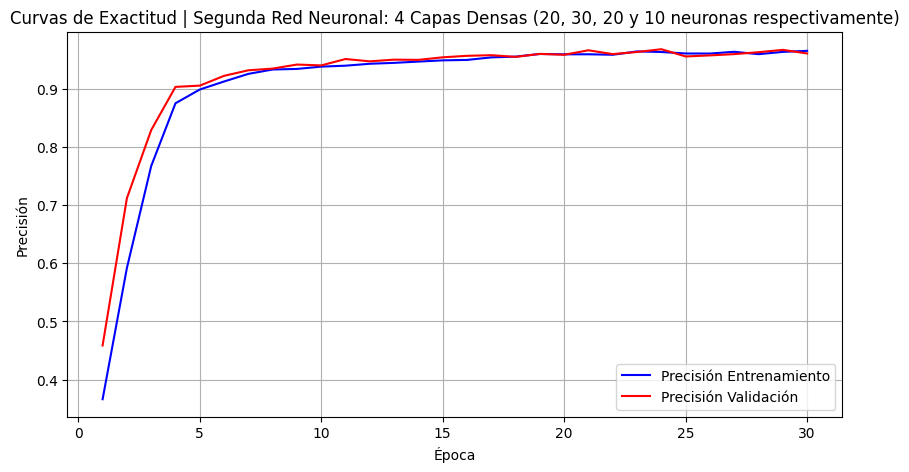

In [347]:
# Graficación de curvas de aprendizaje
graphHistory(rn2_history, rn2_title)

##### Evaluación del Modelo

In [348]:
# Predicciones sobre test
y_pred = rn2_model.predict(X_test_pca)

# Convertir a etiquetas predichas tomando la clase con mayor probabilidad
predicciones_clase = np.argmax(y_pred, axis=1)

# Métricas de evaluación obtenidas por el modelo
rn2_Results = classification_report(y_test_cat_encoded, predicciones_clase, output_dict=True)

print(rn2_Results)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
{'0': {'precision': 0.9393203883495146, 'recall': 0.9948586118251928, 'f1-score': 0.9662921348314607, 'support': 389.0}, '1': {'precision': 0.943069306930693, 'recall': 0.9794344473007712, 'f1-score': 0.9609079445145019, 'support': 389.0}, '2': {'precision': 0.9847328244274809, 'recall': 0.9923076923076923, 'f1-score': 0.9885057471264368, 'support': 390.0}, '3': {'precision': 0.9437340153452686, 'recall': 0.9461538461538461, 'f1-score': 0.9449423815620999, 'support': 390.0}, '4': {'precision': 0.96, 'recall': 0.8615384615384616, 'f1-score': 0.9081081081081082, 'support': 390.0}, '5': {'precision': 0.9823232323232324, 'recall': 0.9974358974358974, 'f1-score': 0.989821882951654, 'support': 390.0}, '6': {'precision': 0.9790575916230366, 'recall': 0.958974358974359, 'f1-score': 0.9689119170984456, 'support': 390.0}, 'accuracy': 0.9615102639296188, 'macro avg': {'precision': 0.9617481941427466, 'recall': 0.9615290450766031, 'f1-score': 0.9610700165989

In [349]:
graphROCAUC(y_pred, y_test_oneHot, 7, rn2_title)

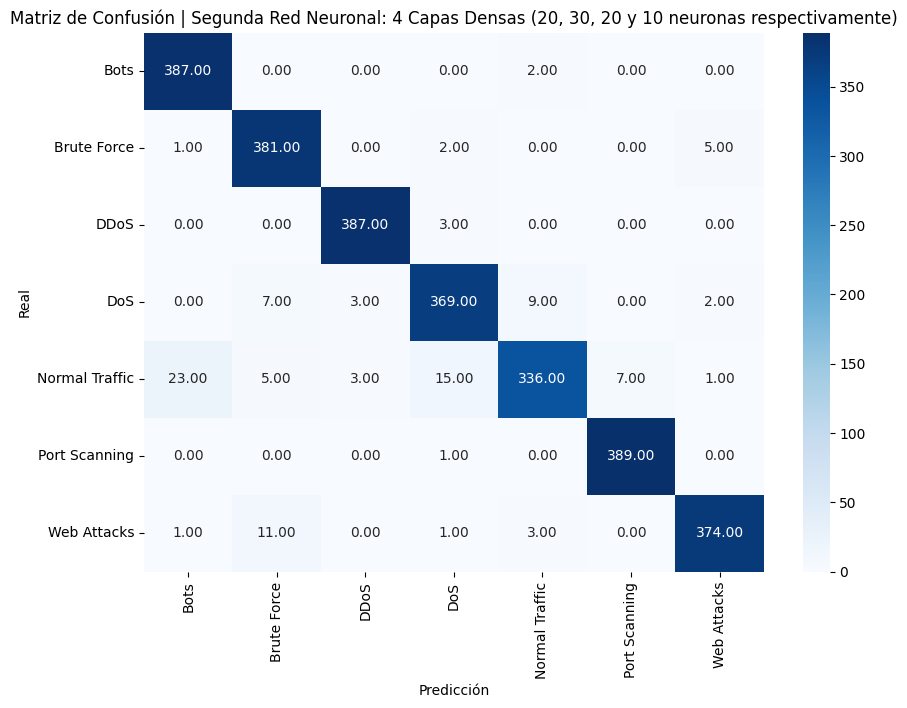

In [350]:
# Mátriz de Confusión

# Convertir a etiquetas enteras
y_true_labels = np.argmax(y_test_oneHot, axis=1)

# Tomar la clase con máxima probabilidad
y_pred_labels = np.argmax(y_pred, axis=1)

# Graficar Matriz de Confusión
graphConfusionMatrix(y_true_labels, y_pred_labels, rn2_title, categories)

#### Tercer Red Neuronal: 1 Capas Densas (20 neuronas)

##### Entrenamiento

In [351]:
rn3_title = "Tercer Red Neuronal: 1 Capas Densas (20 neuronas)"

# Definición de parámetros a utilizar
METRICS = ["accuracy"]
LOSS = "categorical_crossentropy"
EPOCHS = 30
BATCHSIZE = 1000

# Definición de arquitectura y funciones de activación para las capas neuronales
n_neurons = [
    (X_train_pca.shape[1], 'relu'),
    (20, 'relu'),
    (n_output_neurons, 'softmax')
]

# Ejecución y entrenamiento del modelo definido
rn3_history, rn3_model = execNN(X_train_pca, X_test_pca, y_train_oneHot, y_test_oneHot, n_neurons, LOSS, METRICS, EPOCHS, BATCHSIZE, lr=0.01)

Epoch 1/30


/home/mapa/anaconda3/envs/ds/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.3595 - loss: 1.7488 - val_accuracy: 0.5795 - val_loss: 1.4279
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6231 - loss: 1.2302 - val_accuracy: 0.7137 - val_loss: 1.0303
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6774 - loss: 0.9322 - val_accuracy: 0.7350 - val_loss: 0.8323
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7729 - loss: 0.7460 - val_accuracy: 0.7867 - val_loss: 0.6639
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8144 - loss: 0.5939 - val_accuracy: 0.8266 - val_loss: 0.5368
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8455 - loss: 0.4871 - val_accuracy: 0.8446 - val_loss: 0.4509
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8776 - loss: 0.4136 - val_accuracy: 0.8911 - val_loss: 0.3910
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8941 - loss: 0.3649 - val_accuracy: 0.9065 - val_loss: 0.3476
E

##### Curvas de Aprendizaje

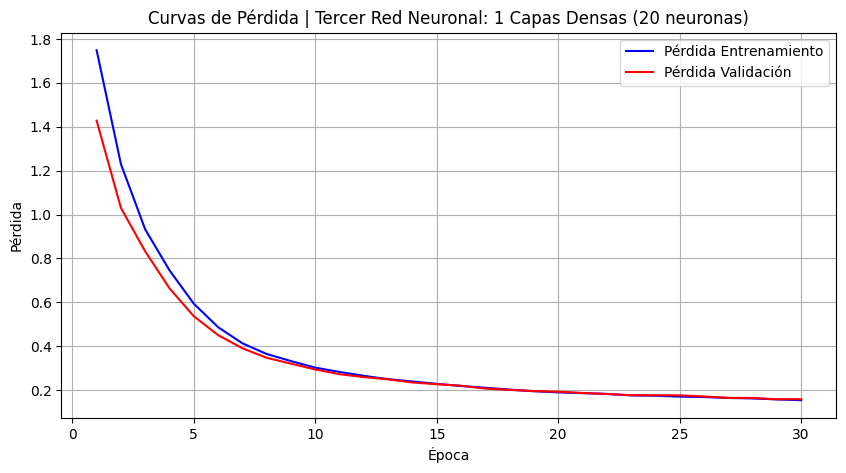

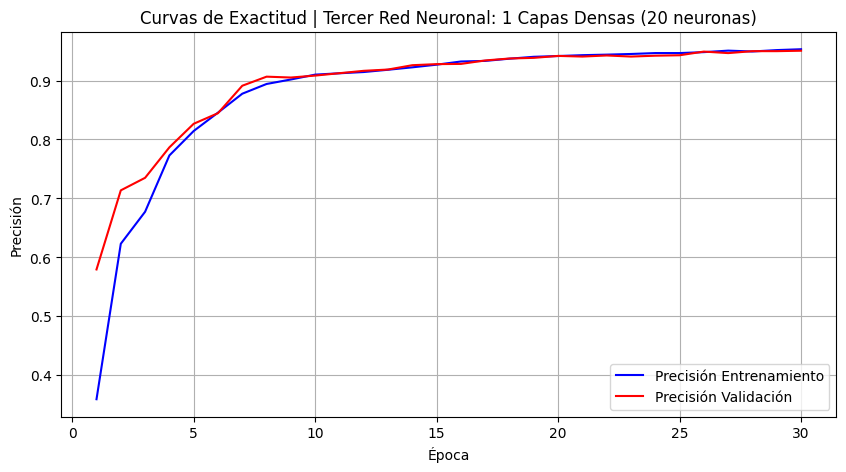

In [352]:
# Graficación de curvas de aprendizaje
graphHistory(rn3_history, rn3_title)

##### Evaluación del Modelo

In [353]:
# Predicciones sobre test
y_pred = rn3_model.predict(X_test_pca)

# Convertir a etiquetas predichas tomando la clase con mayor probabilidad
predicciones_clase = np.argmax(y_pred, axis=1)

# Métricas de evaluación obtenidas por el modelo
rn3_Results = classification_report(y_test_cat_encoded, predicciones_clase, output_dict=True)

print(rn3_Results)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
{'0': {'precision': 0.9598997493734336, 'recall': 0.9845758354755784, 'f1-score': 0.9720812182741116, 'support': 389.0}, '1': {'precision': 0.9028436018957346, 'recall': 0.9794344473007712, 'f1-score': 0.9395807644882861, 'support': 389.0}, '2': {'precision': 0.9629629629629629, 'recall': 1.0, 'f1-score': 0.9811320754716981, 'support': 390.0}, '3': {'precision': 0.9751381215469613, 'recall': 0.9051282051282051, 'f1-score': 0.9388297872340425, 'support': 390.0}, '4': {'precision': 0.9243697478991597, 'recall': 0.8461538461538461, 'f1-score': 0.8835341365461847, 'support': 390.0}, '5': {'precision': 0.9773299748110831, 'recall': 0.9948717948717949, 'f1-score': 0.9860228716645489, 'support': 390.0}, '6': {'precision': 0.9533678756476683, 'recall': 0.9435897435897436, 'f1-score': 0.9484536082474226, 'support': 390.0}, 'accuracy': 0.9505131964809385, 'macro avg': {'precision': 0.9508445763052862, 'recall': 0.9505362675028485, 'f1-score': 0.94994778027

In [354]:
graphROCAUC(y_pred, y_test_oneHot, 7, rn3_title)

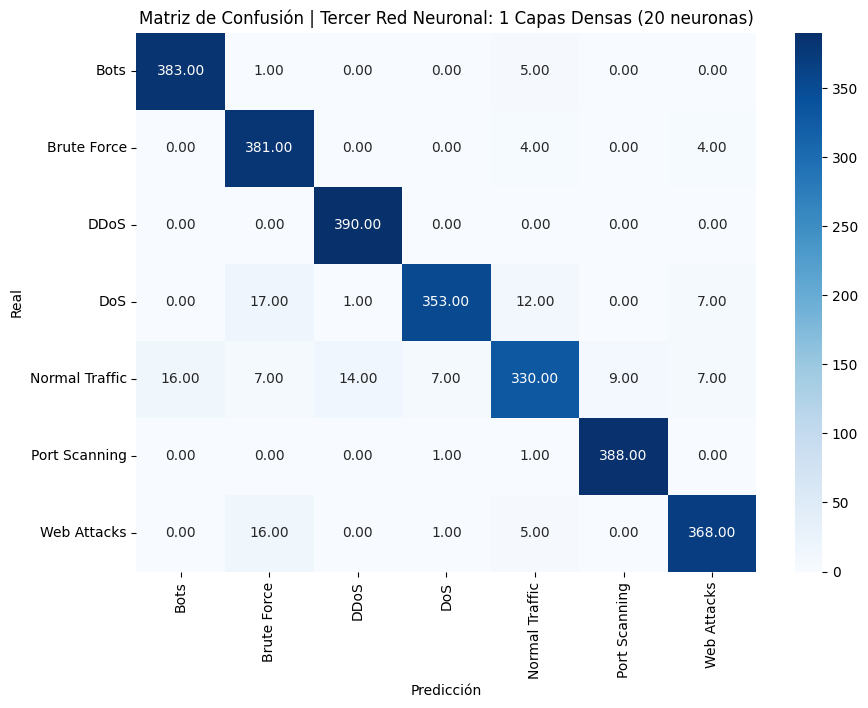

In [355]:
# Mátriz de Confusión

# Convertir a etiquetas enteras
y_true_labels = np.argmax(y_test_oneHot, axis=1)

# Tomar la clase con máxima probabilidad
y_pred_labels = np.argmax(y_pred, axis=1)

# Graficar Matriz de Confusión
graphConfusionMatrix(y_true_labels, y_pred_labels, rn3_title, categories)

## Comparación de Métricas para las 3 Rede Neuronales Densas

A continuación se presentan gráficos en donde se puede apreciar la eficiencia de la clasificación realizada por las tres redes neruonales entrenadas anteriormente con respecto a las métricas de precisión, recuerdo y f1.

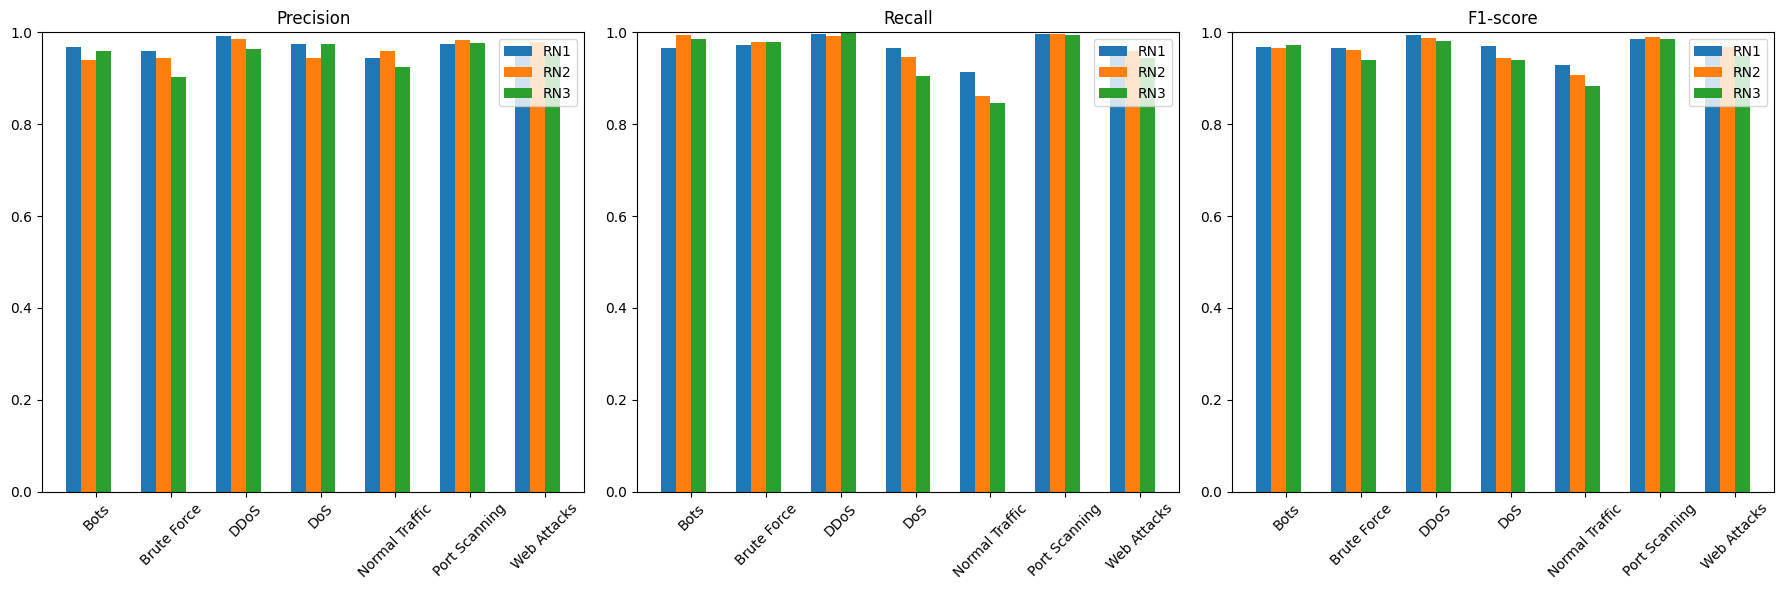

In [373]:
# Convertir cada reporte a DataFrame
df_rn1 = report_to_df(rn1_Results)
df_rn2 = report_to_df(rn2_Results)
df_rn3 = report_to_df(rn3_Results)

# Crear un DataFrame para comparación
df_all = pd.concat([df_rn1.add_suffix('_RN1'),
                    df_rn2.add_suffix('_RN2'),
                    df_rn3.add_suffix('_RN3')], axis=1)

# Graficar las métricas por clase
metrics = ['precision', 'recall', 'f1-score']
classes = categories

fig, axs = plt.subplots(1, 3, figsize=(18,6))

for i, metric in enumerate(metrics):
    ax = axs[i]
    width = 0.2
    x = np.arange(len(classes))
    
    ax.bar(x - 1.5*width, df_rn1[metric], width, label='RN1')
    ax.bar(x - 0.5*width, df_rn2[metric], width, label='RN2')
    ax.bar(x + 0.5*width, df_rn3[metric], width, label='RN3')
    
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0,1)
    ax.legend()

plt.tight_layout()
plt.show()


En la siguiente gráfica se visualiza la distribución de los resultados obtenidos por cada red neuronal con la finalidad de poder conservar la arquitectura de red más eficiente. 

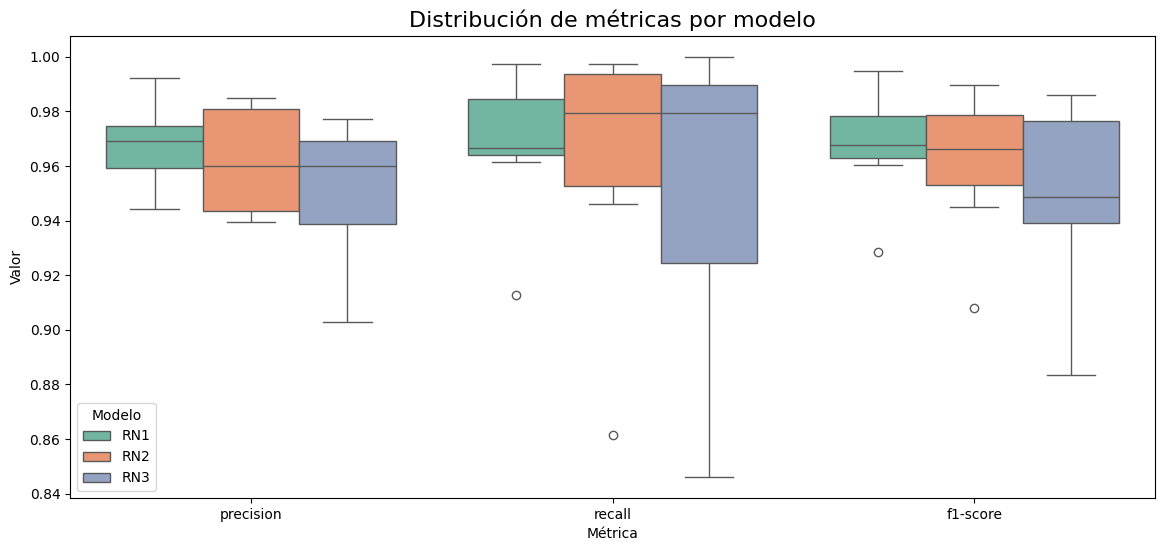

In [374]:
df_long = df_all.reset_index().melt(id_vars="index", var_name="Modelo-Métrica", value_name="Valor")
df_long[["Métrica", "Modelo"]] = df_long["Modelo-Métrica"].str.split("_", expand=True)
df_long = df_long.rename(columns={"index": "Clase"})

df_long2 = df_long.copy()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_long2, x="Métrica", y="Valor", hue="Modelo", palette="Set2")
plt.title("Distribución de métricas por modelo", fontsize=16)
plt.ylabel("Valor")
plt.show()

Con base en la métrica armónica de f1-score, el modelo con mejores resultados fue la red neuronal 1 construida con la siguiente arquitectura y parámetros:

- LOSS = "categorical_crossentropy" <br>
- EPOCHS = 50<br>
- BATCHSIZE = 500<br>
- lr = 0.01<br>
- n_neurons = [
    (n_input_neurons, 'relu'),
    (20, 'relu'),
    (10, 'relu'),
    (n_output_neurons, 'softmax')
]<br>



## K-Fold Cross Validation para el Mejor Modelo de RN

In [ ]:
rn_title = "Red Neuronal: 2 Capas Densas (20 y 10 neuronas respectivamente)"

# Definición de parámetros a utilizar
METRICS = ["accuracy"]
LOSS = "categorical_crossentropy"
EPOCHS = 50
BATCHSIZE = 500

def create_model(loss="categorical_crossentropy", metrics=["accuracy"], lr=0.01):

    model = Sequential()
    model.add(Dense(X_train_pca.shape[1], input_dim=X_train_pca.shape[1], activation="relu"))
    model.add(Dense(20, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(n_output_neurons, activation="sigmoid")) 

    # Optimizador utilizado
    opt = optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return model

clf = KerasClassifier(
    model=create_model,
    loss=LOSS,
    metrics=METRICS,
    lr=0.01,
    epochs=EPOCHS,
    batch_size=BATCHSIZE,
    verbose=0
)

In [ ]:
# Juntar conjuntos para poder ingresarlos al cross validation
X_pca = np.vstack((X_train_pca, X_test_pca))
Y_pca = np.concatenate((y_train, y_test))

print(X_pca.shape)
print(Y_pca.shape)

(13636, 10)
(13636,)


In [ ]:
scores = cross_val_score(clf, X_pca, Y_pca, cv=5)  # 5-fold cross-validation

In [386]:
print("Accuracy por fold:", scores)
print("Accuracy promedio:", np.mean(scores))

Accuracy por fold: [0.95674487 0.95892923 0.90539054 0.96846351 0.91822516]
Accuracy promedio: 0.9415506604423884


De los resultados anteriores se puede observar que el modelo de red neuronal entrenado es capaz de generalizar para 5 perspectivas distintas del conjunto de datos, obteniendo un accuracy promedio de 0.94.

# Resultados

En esta sección se exploran los resultados obtenidos de la comparación entre las métricas obtenidas de la Regresión Logística y la Red Neuronal Densa Final. El objetivo es lograr denotar las principales diferencias en el rendimiento de ambos modelos y así reconocer las virtudes de cada implementación de forma independiente.

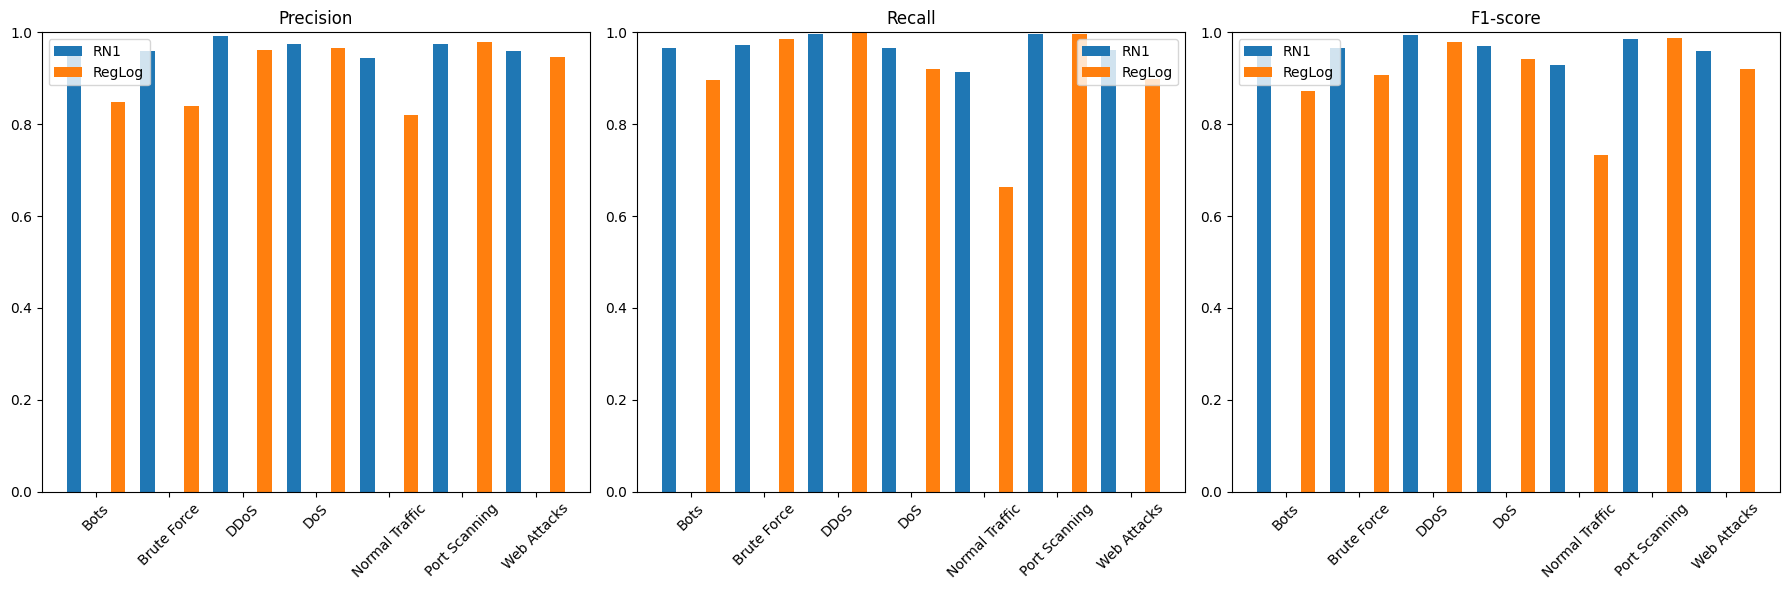

In [ ]:
# Comparación de macro métricas para cada modelo (Regresión Logistica y RN Final
# Convertir cada reporte a DataFrame
df_rn1 = report_to_df(rn1_Results)
df_reglog = report_to_df(reglogResults)

# Crear un DataFrame para comparación
df_all = pd.concat([df_rn1.add_suffix('_RN1'),
                    df_reglog.add_suffix('_RegLog')], axis=1)

# Graficar las métricas por clase
metrics = ['precision', 'recall', 'f1-score']
classes = categories

fig, axs = plt.subplots(1, 3, figsize=(18,6))

for i, metric in enumerate(metrics):
    ax = axs[i]
    width = 0.2
    x = np.arange(len(classes))
    
    ax.bar(x - 1.5*width, df_rn1[metric], width, label='RN1')
    ax.bar(x + 1.5*width, df_reglog[metric], width, label='RegLog')
    
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0,1)
    ax.legend()

plt.tight_layout()
plt.show()


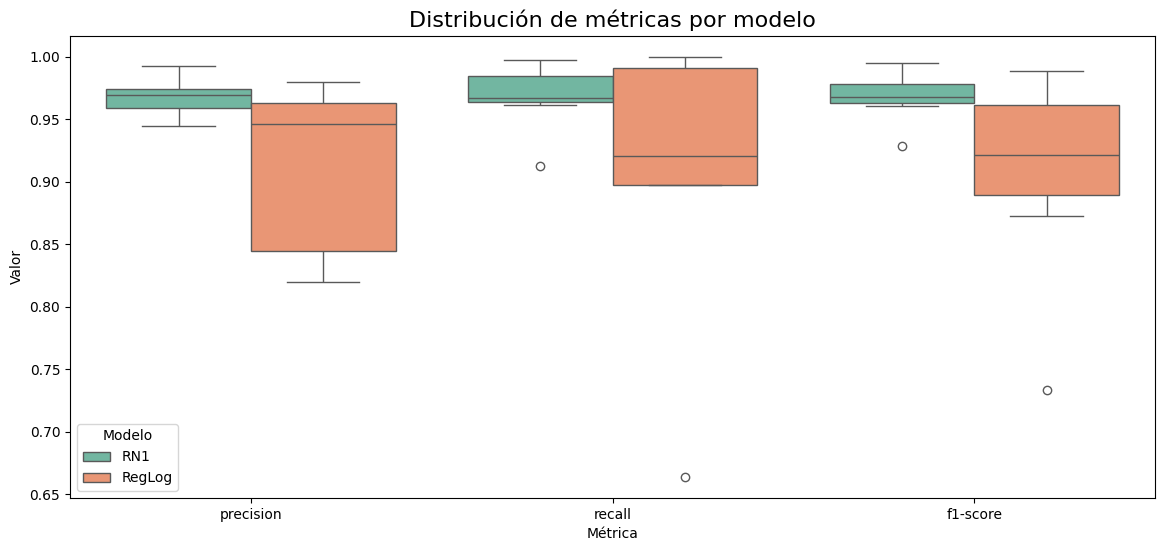

In [ ]:
# Gráfica de distribución de métricas por modelo (Regresión Logistica y RN Final)
df_long = df_all.reset_index().melt(id_vars="index", var_name="Modelo-Métrica", value_name="Valor")
df_long[["Métrica", "Modelo"]] = df_long["Modelo-Métrica"].str.split("_", expand=True)
df_long = df_long.rename(columns={"index": "Clase"})

df_long2 = df_long.copy()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_long2, x="Métrica", y="Valor", hue="Modelo", palette="Set2")
plt.title("Distribución de métricas por modelo", fontsize=16)
plt.ylabel("Valor")
plt.show()

# Exportación de Modelos

In [396]:
# Importación de pickle para serialización de objetos
import pickle


# Objeto Regresión Logistica Optimizado
regLogModel = grid

# Abrir el archivo en modo de escritura binaria
with open('./serialObjects/s_regLogModel.pkl', 'wb') as f:
    # Serializar modelo de Regresión Logistica
    pickle.dump(regLogModel, f)

# Objeto Red Neuronal Optimizada
rnModel = rn1_model

# Abrir el archivo en modo de escritura binaria
with open('./serialObjects/s_rnModel.pkl', 'wb') as f:
    # Serializar modelo de Regresión Logistica
    pickle.dump(rnModel, f)


# Objeto Red Neuronal Optimizada
pcaObject = pca

# Abrir el archivo en modo de escritura binaria
with open('./serialObjects/s_pcaObject.pkl', 'wb') as f:
    # Serializar objeto PCA
    pickle.dump(pcaObject, f)

# Abrir el archivo en modo de escritura binaria
with open('./serialObjects/s_scaler.pkl', 'wb') as f:
    # Serializar Escalador utilizado
    pickle.dump(scaler, f)

# Abrir el archivo en modo de escritura binaria
with open('./serialObjects/s_categories.pkl', 'wb') as f:
    # Serializar Escalador utilizado
    pickle.dump(categories, f)

print("Objetos serializados satisfactoriamente")

Objetos serializados satisfactoriamente
